# Posterior probabilities across models for Insight study (version v5)

John Curtin  
March 29, 2024

### Code Status

In use with iterative improvement.

Updating for use with MATCH

### Notes

Can review online docs for

-   [how to use rstanarm](https://cran.r-project.org/web/packages/rstanarm/vignettes/rstanarm.html)
-   [priors](https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html)
-   [warnings](https://mc-stan.org/misc/warnings.html)
-   [tutorial on rstanarm and shinystan](https://www.tqmp.org/RegularArticles/vol14-2/p099/p099.pdf)
-   [R Bloggers on perf_mod](https://www.r-bloggers.com/2019/12/tidyposteriors-bayesian-approach-to-model-comparison/)

### Set Up Environment

In [ ]:
study <- params$study
version <- params$version
cv <- params$cv


Packages for script

In [ ]:
library(tidyposterior)
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.6     ✔ workflows    1.1.3
✔ modeldata    1.3.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.3.0
✔ recipes      1.0.9     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

Absolute paths

In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- "P:/studydata/match/models/"},
        
        # IOS paths
        Darwin = {
          path_models <- "/Volumes/private/studydata/match/models/"},
        
        # Linux paths
        Linux = {
          path_models <- "~/mnt/private/studydata/match/models/"}
)


Chunk Defaults

In [ ]:
knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)


Source training controls

In [ ]:
# EDA
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_eda.R?raw=true")


ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

### Read in preds and metrics for best model

In [ ]:
auc_wk4 <- read_rds(file.path(path_models, "pp_hybrid_wk4_outcome",
                              str_c("outer_metrics_", 
                                    version, "_", cv, ".rds"))) |> 
  arrange(outer_split_num) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10), 3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc) |> 
  glimpse()


Rows: 30
Columns: 3
$ repeat_num <chr> "repeat1", "repeat1", "repeat1", "repeat1", "repeat1", "rep…
$ fold_num   <chr> "fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold…
$ roc_auc    <dbl> 0.5890269, 0.7058600, 0.6805259, 0.6269727, 0.7406656, 0.75…

Rows: 30
Columns: 3
$ repeat_num <chr> "repeat1", "repeat1", "repeat1", "repeat1", "repeat1", "rep…
$ fold_num   <chr> "fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold…
$ roc_auc    <dbl> 0.6405063, 0.6494382, 0.6066667, 0.5852641, 0.6827004, 0.63…

Rows: 30
Columns: 4
$ repeat_num <chr> "repeat1", "repeat1", "repeat1", "repeat1", "repeat1", "rep…
$ fold_num   <chr> "fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold…
$ week_4     <dbl> 0.5890269, 0.7058600, 0.6805259, 0.6269727, 0.7406656, 0.75…
$ week_26    <dbl> 0.6405063, 0.6494382, 0.6066667, 0.5852641, 0.6827004, 0.63…

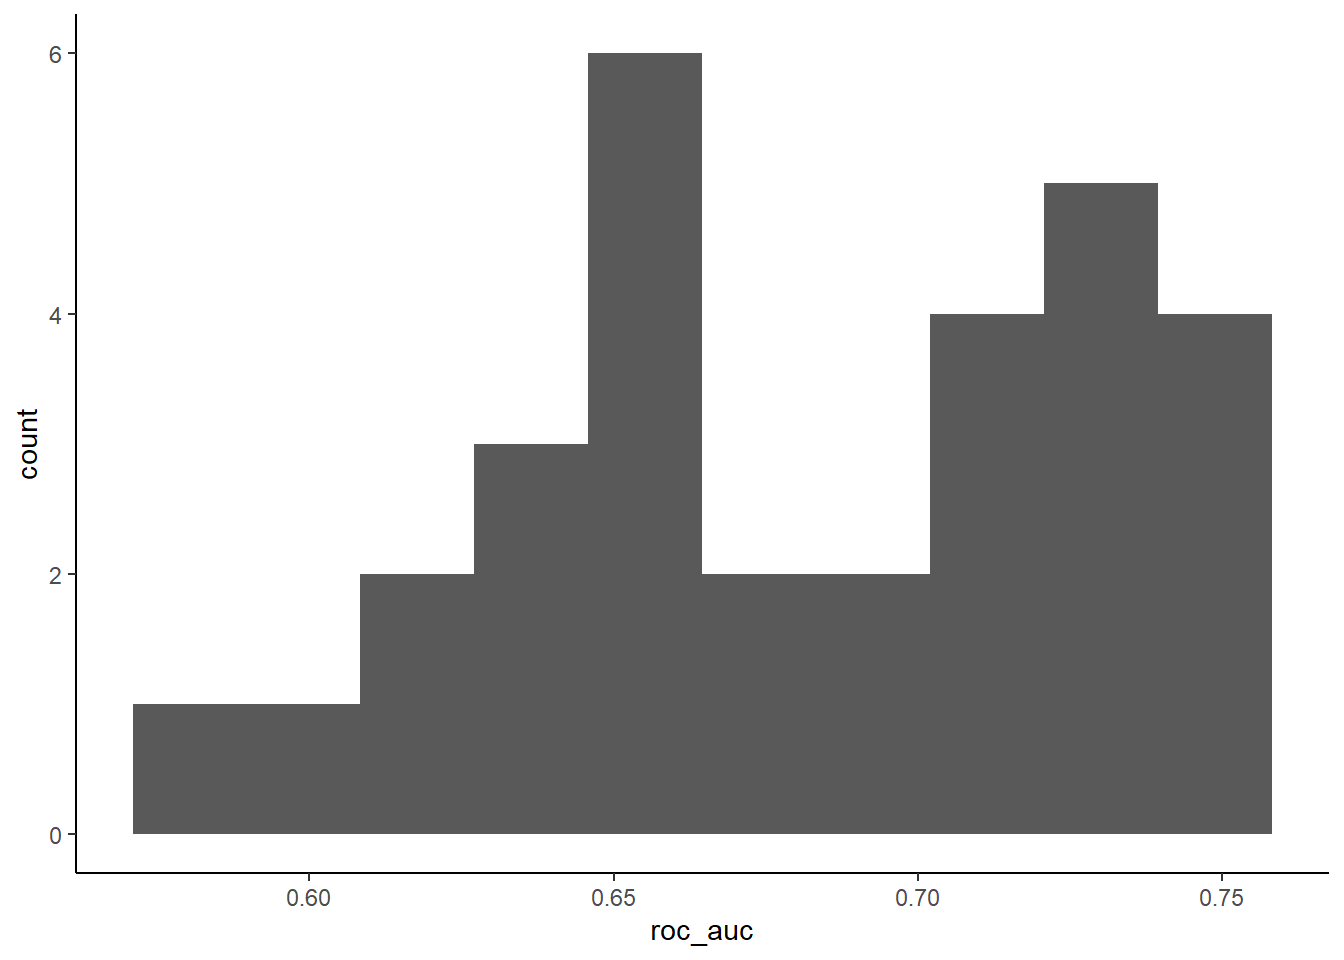

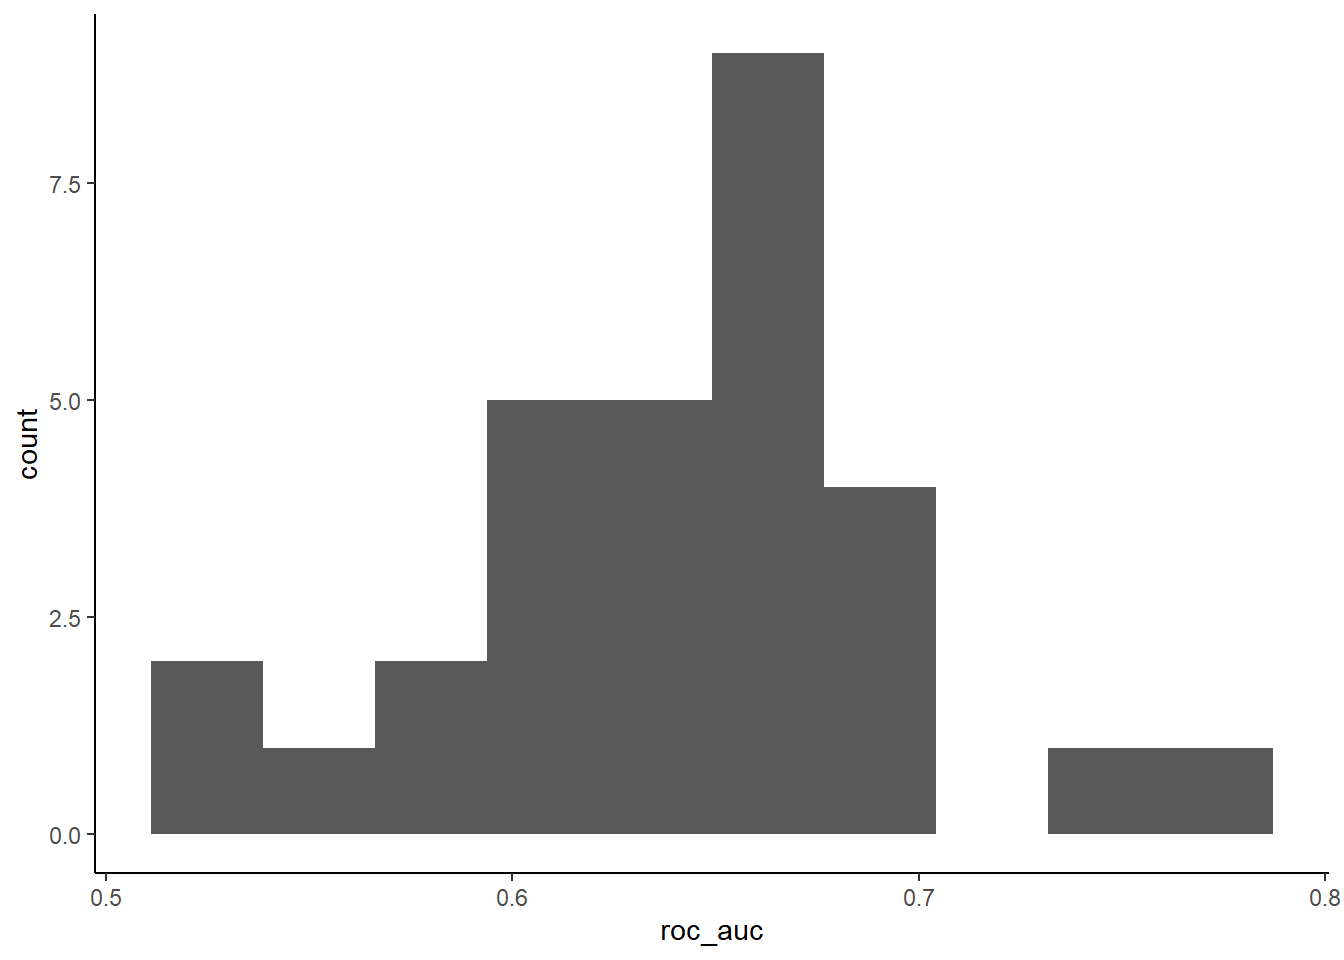

In [ ]:
auc_wk4 %>% 
  ggplot() + 
  geom_histogram(aes(x = roc_auc), bins = 10)


### All models

In [ ]:
# from ?perf_mod()
# Repeated CV (id = repeat, id2 = fold within repeat)

set.seed(101)
pp <- auc |> 
  rename(id = repeat_num,
         id2 = fold_num) |> 
  perf_mod(formula = statistic ~ model + (1 | id2/id), 
           # prior_intercept = rstanarm::student_t(autoscale = TRUE),
           # prior = rstanarm::student_t(autoscale = TRUE),
           transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
           iter = 2000, chains = 4,  
           adapt_delta = .99,
           # cores = 4, seed = 12345,
           family = gaussian, 
  )  



SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.1 seconds (Warm-up)
Chain 1:                0.784 seconds (Sampling)
Chain 1:                1.884 

In [ ]:
rstanarm::prior_summary(pp$stan)


Priors for model 'pp$stan' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 0.67, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0.67, scale = 0.62)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 1.2)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 4)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

In [ ]:
summary(pp$stan)



Model Info:
 function:     stan_glmer
 family:       gaussian [identity]
 formula:      statistic ~ model + (1 | id2/id)
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 60
 groups:       id:id2 (30), id2 (10)

Estimates:
                                        mean   sd   10%   50%   90%
(Intercept)                            0.6    0.0  0.5   0.6   0.6 
modelweek_4                            0.2    0.0  0.1   0.2   0.2 
b[(Intercept) id:id2:repeat1:fold1]   -0.2    0.1 -0.3  -0.1   0.0 
b[(Intercept) id:id2:repeat1:fold10]  -0.2    0.1 -0.3  -0.2   0.0 
b[(Intercept) id:id2:repeat1:fold2]    0.1    0.1 -0.1   0.1   0.2 
b[(Intercept) id:id2:repeat1:fold3]   -0.1    0.1 -0.2  -0.1   0.1 
b[(Intercept) id:id2:repeat1:fold4]   -0.2    0.1 -0.3  -0.2   0.0 
b[(Intercept) id:id2:repeat1:fold5]    0.2    0.1  0.0   0.2   0.3 
b[(Intercept) id:id2:repeat1:fold6]    0.1    0.1  0.0   0.1   0.2 
b[(Intercept) id:id2:r

In [ ]:
# shinystan::launch_shinystan(pp$stan)


In [ ]:
pp %>%  write_rds(file.path(path_models, 
                            str_c("posteriors_", version, "_nested.rds")))


### Model posterier CIs

In [ ]:
pp_tidy <- pp %>% 
  tidy(seed = 123)

q = c(.025, .5, .975)
pp_tidy |> 
  group_by(model) |> 
  summarize(median = quantile(posterior, probs = q[2]),
            lower = quantile(posterior, probs = q[1]), 
            upper = quantile(posterior, probs = q[3])) |> 
  mutate(model = factor(model, levels = c("week_26", "week_4"),
                        labels = c("Week 26", "Week 4")),
         y = 1000) |> 
  arrange(model)


# A tibble: 2 × 5
  model   median lower upper     y
  <fct>    <dbl> <dbl> <dbl> <dbl>
1 Week 26  0.640 0.619 0.661  1000
2 Week 4   0.684 0.665 0.703  1000

### Model contrasts

# A tibble: 1 × 9
  contrast          probability   mean  lower  upper  size pract_neg pract_equiv
  <chr>                   <dbl>  <dbl>  <dbl>  <dbl> <dbl>     <dbl>       <dbl>
1 week_4 vs week_26           1 0.0439 0.0275 0.0601  0.01         0     0.00075
  pract_pos
      <dbl>
1     0.999

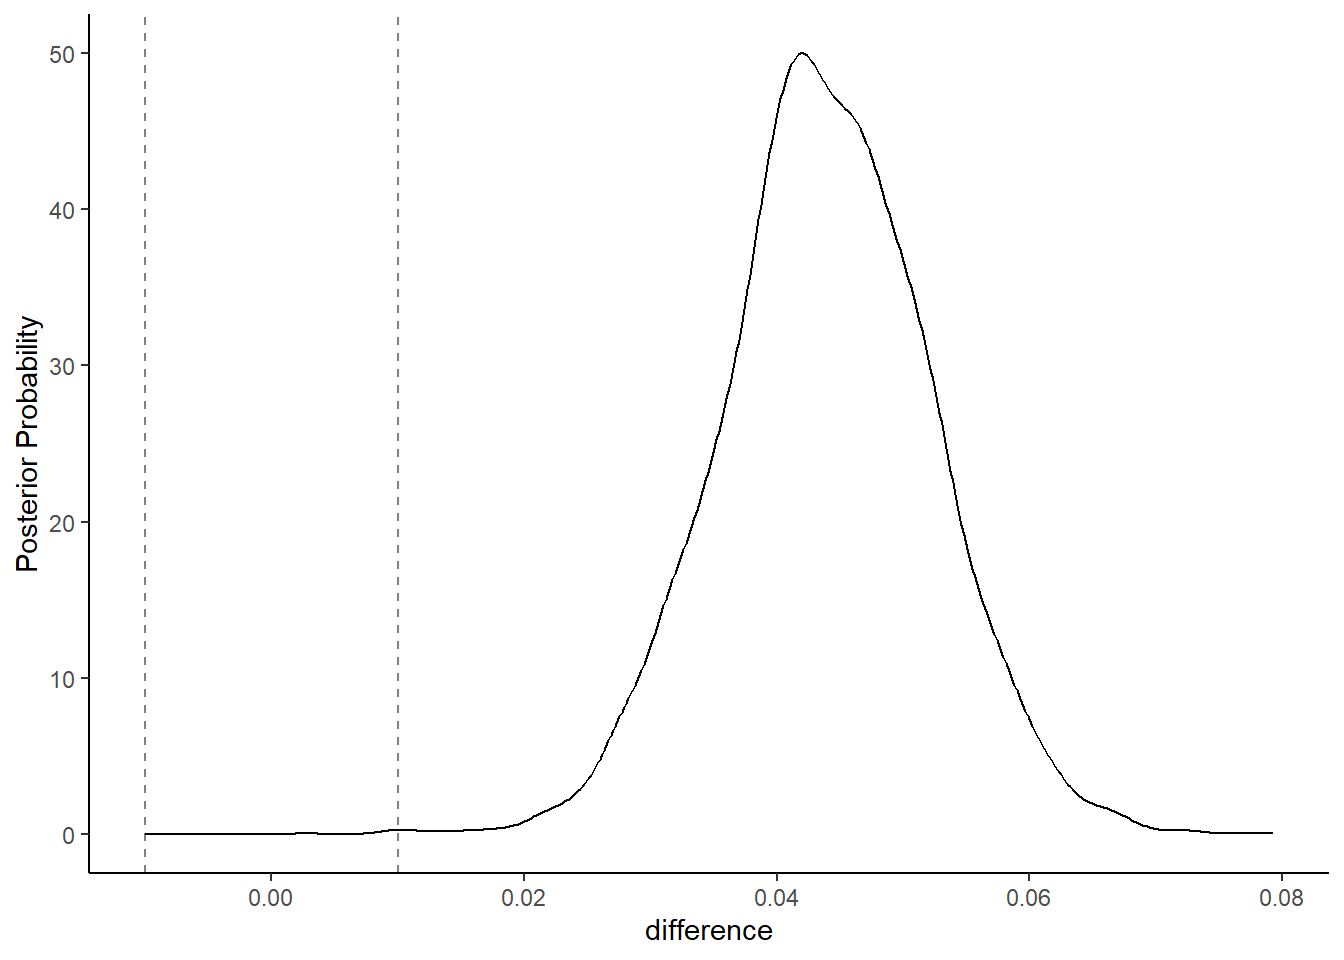

In [ ]:
pp_contrasts <- contrast_models(pp, 
                                list("week_4"), 
                                list("week_26"))
summary(pp_contrasts, size = .01, prob = 0.95)


Here are contrasts against 0 rather than using ROPE

In [ ]:
pp_contrasts |> 
  mutate(wk4_gt_wk26 = if_else(difference > 0, 1, 0)) |>
  pull(wk4_gt_wk26) |> 
  mean()


[1] 1

### Plots

Model posteriors

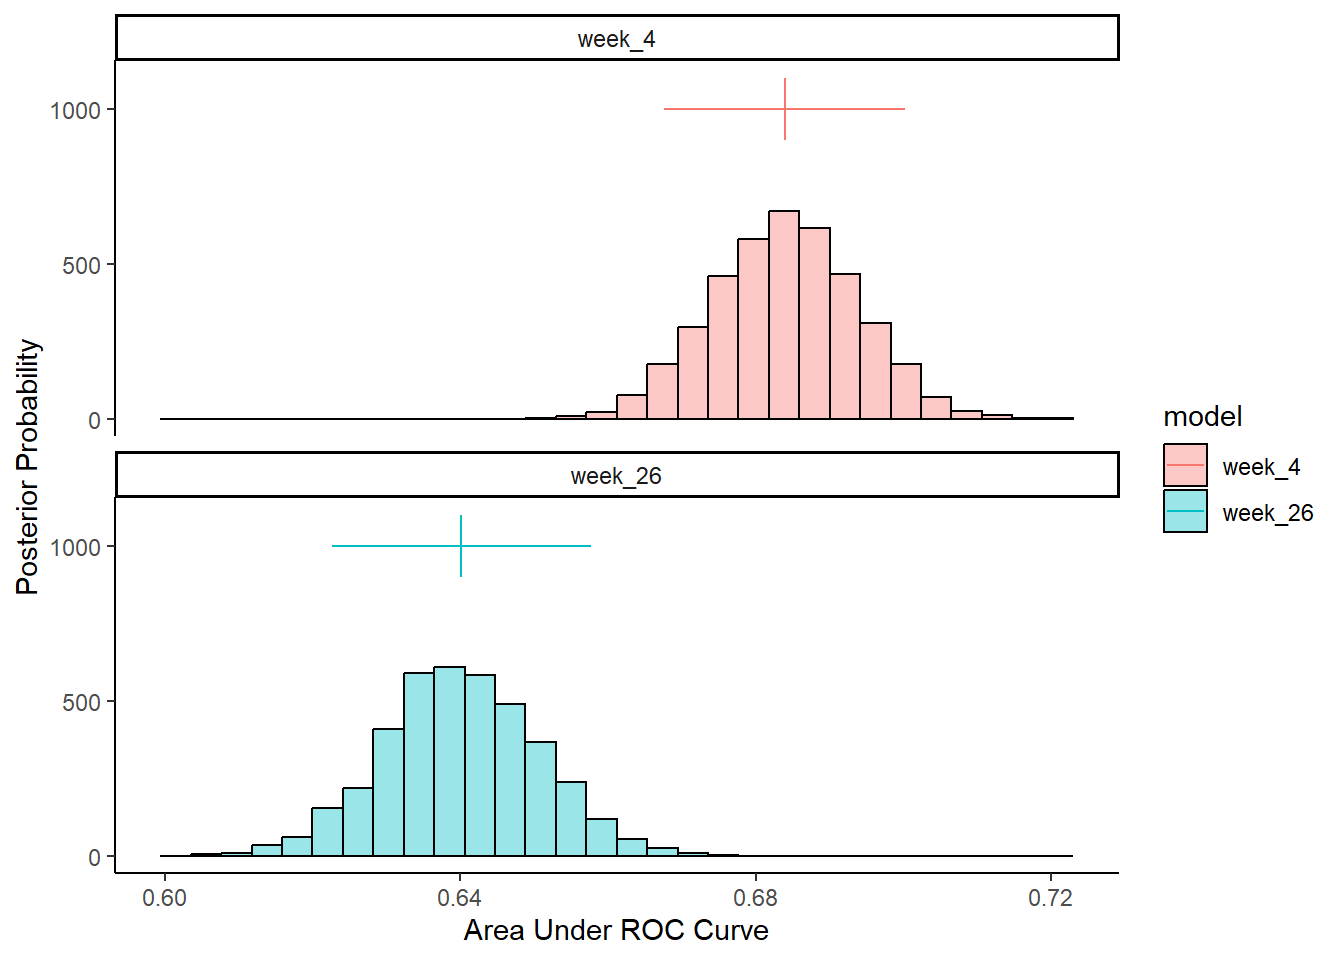

In [ ]:
ci <- pp_tidy |> 
  summary() |> 
  mutate(model = factor(model, levels = c("week_4", "week_26")),
         y = 1000) 

pp_tidy |> 
  mutate(model = factor(model, levels = c("week_4", "week_26"))) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y + 100, yend = y - 100, x = mean, xend = mean,
                             color = model),
               data = ci) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper, color = model),
               data = ci) +
  facet_wrap(~model, ncol = 1) +
  scale_y_continuous("Posterior Probability", breaks = c(0, 500, 1000)) +
  # ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve")


model contrast posteriors

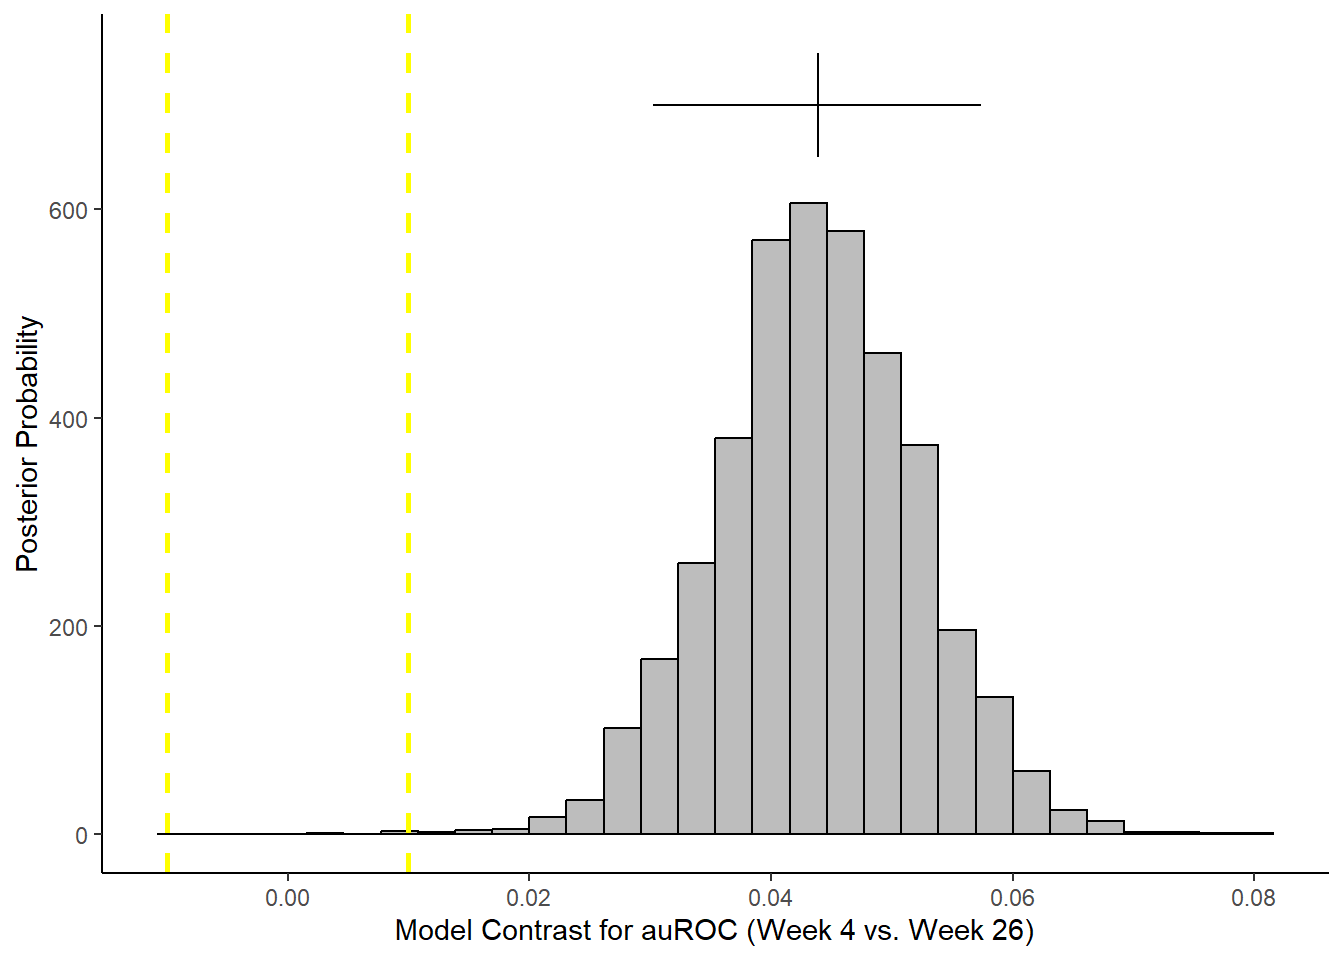

In [ ]:
ci_con <- pp |>
  contrast_models(list("week_4"), 
                  list("week_26")) |> 
  summary(size = .01) |> 
  mutate(contrast = factor(contrast, 
                           levels = c("week_4 vs week_26"),
                           labels = c("week 4 vs. week 26")),
         y = 700)

pp |> 
  tidy(seed = 123) |>   
  group_by(model) |> 
  mutate(sample = row_number()) |> 
  ungroup() |> 
  pivot_wider(names_from = model, values_from = posterior) |> 
  mutate(posterior = week_4 - week_26) |> 
  ggplot() +
  geom_histogram(aes(x = posterior), 
                 color = "black", alpha = .4, bins = 30) +
  geom_vline(xintercept = -.01, color = "yellow", linetype = "dashed", linewidth = 1) +
  geom_vline(xintercept = .01, color = "yellow", linetype = "dashed", linewidth = 1) +
  geom_segment(mapping = aes(y = y+50, yend = y-50, x = mean, xend = mean), 
               data = ci_con) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper), 
               data = ci_con) +
  ylab("Posterior Probability") +
  xlab("Model Contrast for auROC (Week 4 vs. Week 26)")
